# CPU Info
Get-WmiObject Win32_Processor | Select-Object Name, MaxClockSpeed, NumberOfCores

# GPU Info (requires NVIDIA-SMI)
nvidia-smi -q -d POWER

![alt text](image.png)



# The tdp(thermal design power) for the system is as follows:

# i5-45W
# gtx 1650 - 50W



![alt text](image-1.png)

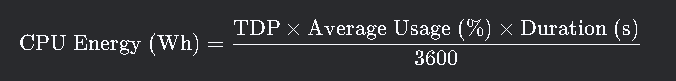

![alt text](image-2.png)

In [14]:
%pip install pynvml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
%pip install pyRAPL psutil GPUtil


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import pyRAPL
import psutil
from GPUtil import GPUtil
import time 
import platform
import pynvml


class EnergyTracker:
    def __init__(self):
        # Hardware-specific TDP values
        self.CPU_TDP = 45    # Watts (i5-9300H)
        self.GPU_TDP = 50    # Watts (GTX 1650 mobile)
        
        # Initialize GPU monitoring
        self.gpu_mode = "tdp_estimation"  # Default mode
        try:
            pynvml.nvmlInit()
            self.gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
            self.gpu_power_limit = pynvml.nvmlDeviceGetPowerManagementLimit(self.gpu_handle) / 1000
            self.gpu_mode = "direct_measurement"
        except Exception as e:
            self.gpu_power_limit = self.GPU_TDP
            self.gpu_handle = None
            self.gpu_mode = "tdp_estimation"
            
        print(f"\nGPU Monitoring Mode: {self.gpu_mode.upper()}")
        if self.gpu_mode == "direct_measurement":
            print(f"- Using NVML for direct power measurements")
        else:
            print(f"- Using TDP estimation with GPU load monitoring")

    def start(self):
        self.start_time = time.time()
        self.initial_cpu_usage = psutil.cpu_percent()
        self.initial_gpu_power = self._get_gpu_power()

    def _get_gpu_power(self):
        """Get GPU power in watts using NVML if available"""
        try:
            return pynvml.nvmlDeviceGetPowerUsage(self.gpu_handle) / 1000
        except:
            # Fallback to TDP-based estimation
            gpus = GPUtil.getGPUs()
            if gpus:
                return self.gpu_power_limit * gpus[0].load
            return 0

    def stop(self):
        duration = time.time() - self.start_time
        
        # CPU Energy Calculation
        final_cpu_usage = psutil.cpu_percent()
        avg_cpu_usage = (self.initial_cpu_usage + final_cpu_usage) / 200  # Convert % to fraction
        cpu_energy = (self.CPU_TDP * avg_cpu_usage * duration) / 3600  # Wh

        # GPU Energy Calculation
        final_gpu_power = self._get_gpu_power()
        if self.gpu_handle:  # Use actual measurements if available
            avg_gpu_power = (self.initial_gpu_power + final_gpu_power) / 2
            gpu_energy = (avg_gpu_power * duration) / 3600
        else:  # Fallback to TDP estimation
            gpu_energy = (self.GPU_TDP * (final_gpu_power/self.GPU_TDP) * duration) / 3600

        return {
            "cpu_wh": cpu_energy ,
            "gpu_wh": gpu_energy ,
            "total_wh": (cpu_energy + gpu_energy),
            "duration": duration
        }

# -------------------------------
# Prioritized Replay Buffer (Fixed)
# -------------------------------
class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, alpha=0.6):
        priorities = self.priorities[:len(self.buffer)] ** alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-0.5)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

# -------------------------------------------
# Mobile Edge Computing Environment (Updated)
# -------------------------------------------
class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10):
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        
        # Mobile Devices (MD) parameters
        self.md_compute = np.random.uniform(1.0, 3.0, num_md)        # GHz
        self.md_battery = np.random.randint(3000, 5001, num_md)      # mAh
        self.md_energy_local = np.random.uniform(1000, 3000, num_md) # mA/s (processing)
        self.md_energy_tx = np.random.uniform(0.1, 0.3, num_md)      # mAh per MB (transmission)
        
        # Edge Servers (ES) parameters
        self.es_compute = np.random.uniform(3.0, 5.0, num_es)        # GHz
        self.es_battery = np.random.randint(10000, 20001, num_es)    # mAh
        self.es_energy_process = np.random.uniform(500, 1500, num_es) # mA/s (processing)
        
        # Task parameters
        self.task_requirements = np.random.randint(100, 500, num_tasks)  # MB
        self.task_to_md = np.random.randint(0, num_md, num_tasks)  # Assign tasks to MDs
        
        self.reset()

    def reset(self):
        # Reset batteries to initial values
        self.md_battery = np.random.randint(3000, 5001, self.num_md)
        self.es_battery = np.random.randint(10000, 20001, self.num_es)
        
        self.current_task = 0
        self.completed_tasks = 0
        self.total_energy = 0
        self.violations = 0
        return self._get_state()

    def _get_state(self):
        if self.current_task >= self.num_tasks:
            return np.zeros(self.state_size)
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        
        # Normalize values
        state = [
            self.md_battery[md_idx] / 5000,
            self.md_compute[md_idx] / 3.0,
            task_size / 500,
            self.md_energy_local[md_idx] / 3000,
            self.md_energy_tx[md_idx] / 0.3
        ]
        
        # Add ES parameters
        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / 20000,
                self.es_compute[es_idx] / 5.0,
                self.es_energy_process[es_idx] / 1500
            ])
        
        # Add task progress
        state.append(self.current_task / self.num_tasks)
        
        self.state_size = len(state)
        return np.array(state)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return np.zeros(self.state_size), 0, True, {}
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        reward = 0
        done = False
        success = False
        device_used = ""
        energy_consumed = 0
        
        # Capture initial battery states
        initial_md_battery = self.md_battery[md_idx]
        initial_es_battery = self.es_battery[action-1] if action != 0 else 0

        # Process current task
        if action == 0:  # Local processing
            task_cycles = task_size * 1e6  # Convert MB to cycles
            processing_time = task_cycles / (self.md_compute[md_idx] * 1e9)  # Seconds
            energy_needed = processing_time * self.md_energy_local[md_idx]  # mA
            
            if initial_md_battery >= energy_needed:
                # Successful local processing
                self.md_battery[md_idx] -= energy_needed
                self.total_energy += energy_needed
                self.completed_tasks += 1
                
                # Reward components
                task_value = (task_size / 500) * 15  # Base reward scaled by task size
                energy_efficiency = (energy_needed / task_size) * 3  # Penalize energy per MB
                battery_impact = (energy_needed / initial_md_battery) * 8  # Penalize battery drain
                
                reward = task_value - energy_efficiency - battery_impact
                success = True
                energy_consumed = energy_needed
                device_used = f"MD{md_idx}"
            else:
                # Failed local processing
                self.violations += 1
                reward = -(task_size / 500) * 15  # Penalty proportional to task size
                self.md_battery[md_idx] = 0
        else:  # Offload to ES
            es_idx = action - 1
            if es_idx >= self.num_es:
                es_idx = self.num_es - 1
                
            # Transmission energy (per-MB rate)
            tx_energy = task_size * self.md_energy_tx[md_idx]
            
            # Edge processing (time-based)
            task_cycles = task_size * 1e6  # Convert MB to cycles
            processing_time = task_cycles / (self.es_compute[es_idx] * 1e9)  # Seconds
            process_energy = processing_time * self.es_energy_process[es_idx]  # mA
            
            if (initial_md_battery >= tx_energy and 
                self.es_battery[es_idx] >= process_energy):
                
                # Successful offload
                self.md_battery[md_idx] -= tx_energy
                self.es_battery[es_idx] -= process_energy
                self.total_energy += tx_energy + process_energy
                self.completed_tasks += 1

                # Reward components
                task_value = (task_size / 500) * 15
                total_energy = tx_energy + process_energy
                energy_efficiency = (total_energy / task_size) * 2.5
                md_impact = (tx_energy / initial_md_battery) * 5
                es_impact = (process_energy / self.es_battery[es_idx]) * 5
                
                reward = task_value - energy_efficiency - md_impact - es_impact
                success = True
                energy_consumed = total_energy
                device_used = f"ES{es_idx}"
            else:
                # Failed offload
                self.violations += 1
                reward = -(task_size / 500) * 15
                if self.md_battery[md_idx] < tx_energy:
                    self.md_battery[md_idx] = 0
                if self.es_battery[es_idx] < process_energy:
                    self.es_battery[es_idx] = 0
        
        # Print step details
        print(f"Task {self.current_task+1} ({task_size}MB) - Device: {device_used if success else 'None'}")
        if success:
            print(f"  Energy used: {energy_consumed:.1f}mAh")
            print(f"  MD{md_idx} battery: {self.md_battery[md_idx]:.1f}mAh")
            if action != 0:
                print(f"  ES{es_idx} battery: {self.es_battery[es_idx]:.1f}mAh")
        else:
            print("  Failed - insufficient battery")
        
        # Move to next task
        self.current_task += 1
        done = self.current_task >= self.num_tasks
        
        # Get next state
        next_state = self._get_state()
        
        # Episode completion bonus
        if done:
            completion_ratio = self.completed_tasks / self.num_tasks
            reward += completion_ratio * 20  # Scaled completion bonus
            reward -= (self.violations / self.num_tasks) * 25  # Scaled violation penalty
        
        return next_state, reward, done, {}

# -------------------------------
# Dueling DQN Agent (Updated)
# -------------------------------
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_dueling_dqn()
        self.target_model = self._build_dueling_dqn()
        self.update_target_network()

    def _build_dueling_dqn(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(128, activation='relu')(inputs)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        
        # Value stream
        value = tf.keras.layers.Dense(1)(x)
        
        # Advantage stream
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        
        # Combine streams
        mean_advantage = tf.keras.layers.Lambda(
            lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        adjusted_advantage = tf.keras.layers.Subtract()([advantage, mean_advantage])
        outputs = tf.keras.layers.Add()([value, adjusted_advantage])
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return

        samples, indices, weights = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        
        states = np.array(states)
        next_states = np.array(next_states)
        
        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        
        td_errors = []
        for i in range(self.batch_size):
            if dones[i]:
                target = rewards[i]
            else:
                target = rewards[i] + self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target
        
        self.model.fit(states, current_q, sample_weight=weights,
                      batch_size=self.batch_size, verbose=0)
        
        self.memory.update_priorities(indices, td_errors)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# -------------------------------
# Training and Evaluation (Updated)
# -------------------------------
def train_agent(episodes=100):
    tracker = EnergyTracker()
    env = MECEnvironment(num_md=3, num_es=2, num_tasks=10)
    state_size = env._get_state().shape[0]  # Initialize state size
    agent = DQNAgent(state_size=state_size, action_size=1 + env.num_es)
    
    rewards = []
    completion_rates = []
    energy_consumptions = []
    total_energy = 0.0
    total_cpu_energy = 0.0
    total_gpu_energy = 0.0 
    
    for episode in range(episodes):
        tracker.start()
        state = env.reset()
        total_reward = 0
        done = False
        
        print(f"\n=== Episode {episode+1} ===")
        print("Initial Batteries:")
        print(f"MDs: {env.md_battery}")
        print(f"ESs: {env.es_battery}")
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if len(agent.memory.buffer) > agent.batch_size:
                agent.replay()
        
        if episode % 10 == 0:
            agent.update_target_network()
            
        
       
        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks/env.num_tasks)
        energy_consumptions.append(env.total_energy)
        
        energy = tracker.stop()
        total_energy += energy['total_wh']
        total_cpu_energy += energy['cpu_wh']
        total_gpu_energy += energy['gpu_wh']
        
        print("\nEpisode Summary:")
        print(f"Completed tasks: {env.completed_tasks}/{env.num_tasks}")
        print(f"Total energy consumed: {env.total_energy:.1f}mAh")
        print(f"Final MD batteries: {np.round(env.md_battery, 1)}")
        print(f"Final ES batteries: {np.round(env.es_battery, 1)}")
        print(f"Total reward: {total_reward:.1f}")
        print(f"Epsilon: {agent.epsilon:.3f}\n")
        
        print(f"Energy Consumption:\n"
      f"  CPU: {energy['cpu_wh']*3600:.2f} J\n"
      f"  GPU: {energy['gpu_wh']*3600:.4f} J\n"
      f"  Total: {energy['total_wh']*3600:.4f} J")
    
    print(f"\nTraining Complete")
    print(f"Total Energy Used: {total_energy *3600:.2f} J")
    print(f"Total CPU Energy Used: {total_cpu_energy *3600:.2f} J")
    print(f"Total GPU Energy Used: {total_gpu_energy *3600:.2f} J")
    print(f"Average per Episode: {(total_energy/episodes)*3600:.2f} J")
    
    
    # Plot training results
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    plt.plot(rewards)
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1,3,2)
    plt.plot(completion_rates)
    plt.title('Task Completion Rate')
    plt.xlabel('Episode')
    plt.ylabel('Completion Rate')
    
    plt.subplot(1,3,3)
    plt.plot(energy_consumptions)
    plt.title('Energy Consumption')
    plt.xlabel('Episode')
    plt.ylabel('Total Energy (mAh)')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train_agent(episodes=150)


GPU Monitoring Mode: TDP_ESTIMATION
- Using TDP estimation with GPU load monitoring


=== Episode 1 ===
Initial Batteries:
MDs: [3691 4858 3310]
ESs: [17997 12310]
Task 1 (352MB) - Device: ES0
  Energy used: 142.8mAh
  MD2 battery: 3260.0mAh
  ES0 battery: 17903.0mAh
Task 2 (429MB) - Device: ES1
  Energy used: 249.5mAh
  MD0 battery: 3627.0mAh
  ES1 battery: 12123.0mAh
Task 3 (447MB) - Device: ES1
  Energy used: 259.9mAh
  MD0 battery: 3561.0mAh
  ES1 battery: 11928.0mAh
Task 4 (124MB) - Device: ES0
  Energy used: 50.3mAh
  MD2 battery: 3242.0mAh
  ES0 battery: 17869.0mAh
Task 5 (146MB) - Device: ES0
  Energy used: 68.4mAh
  MD1 battery: 4828.0mAh
  ES0 battery: 17830.0mAh
Task 6 (191MB) - Device: ES1
  Energy used: 121.6mAh
  MD1 battery: 4789.0mAh
  ES1 battery: 11845.0mAh
Task 7 (412MB) - Device: ES1
  Energy used: 236.5mAh
  MD2 battery: 3184.0mAh
  ES1 battery: 11666.0mAh
Task 8 (168MB) - Device: ES0
  Energy used: 68.2mAh
  MD2 battery: 3160.0mAh
  ES0 battery: 17785.0mAh
Task 9

KeyboardInterrupt: 

# Ran with energy Tracker
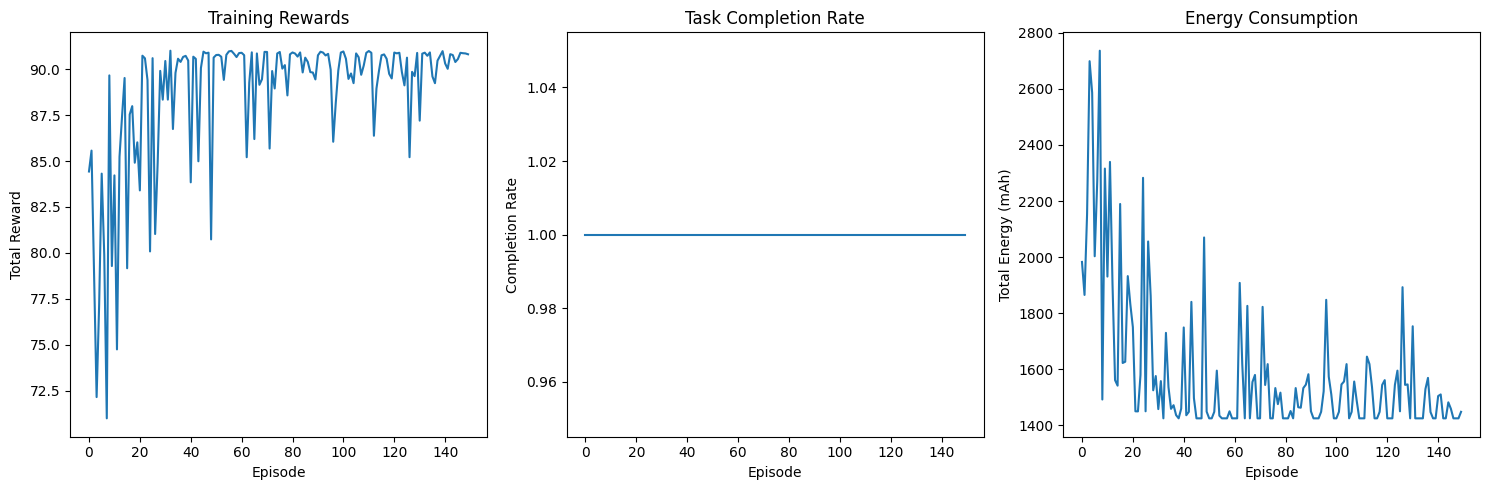

# Energy Consumption of CPU+GPU

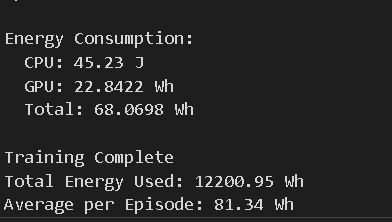

Gpu load is beng calculated sing GPUtil.getGPUs()

CPU load is being calculated as follows:

self.initial_cpu_usage = psutil.cpu_percent()
final_cpu_usage = psutil.cpu_percent()

avg_cpu_usage = (self.initial_cpu_usage + final_cpu_usage) / 200  

cpu_energy = (self.CPU_TDP * avg_cpu_usage * duration) / 3600  # Wh


=== Episode 1 ===
Initial Batteries:
MDs: [4463 4376 4126]
ESs: [16439 19226]
Task 1 (408MB) - Device: MD1
  Energy used: 540.5mAh
  MD1 battery: 3835.0mAh
Task 2 (448MB) - Device: ES1
  Energy used: 197.1mAh
  MD1 battery: 3704.0mAh
  ES1 battery: 19159.0mAh
Task 3 (418MB) - Device: ES0
  Energy used: 274.4mAh
  MD1 battery: 3582.0mAh
  ES0 battery: 16286.0mAh
Task 4 (181MB) - Device: ES1
  Energy used: 58.2mAh
  MD0 battery: 4431.0mAh
  ES1 battery: 19132.0mAh
Task 5 (488MB) - Device: MD2
  Energy used: 280.4mAh
  MD2 battery: 3845.0mAh
Task 6 (243MB) - Device: MD0
  Energy used: 160.8mAh
  MD0 battery: 4270.0mAh
Task 7 (199MB) - Device: MD0
  Energy used: 131.7mAh
  MD0 battery: 4138.0mAh
Task 8 (333MB) - Device: MD0
  Energy used: 220.3mAh
  MD0 battery: 3917.0mAh
Task 9 (168MB) - Device: MD1
  Energy used: 222.6mAh
  MD1 battery: 3359.0mAh
Task 10 (386MB) - Device: ES1
  Energy used: 124.1mAh
  MD0 battery: 3850.0mAh
  ES1 battery: 19074.0mAh

Episode Summary:
Completed tasks: 10

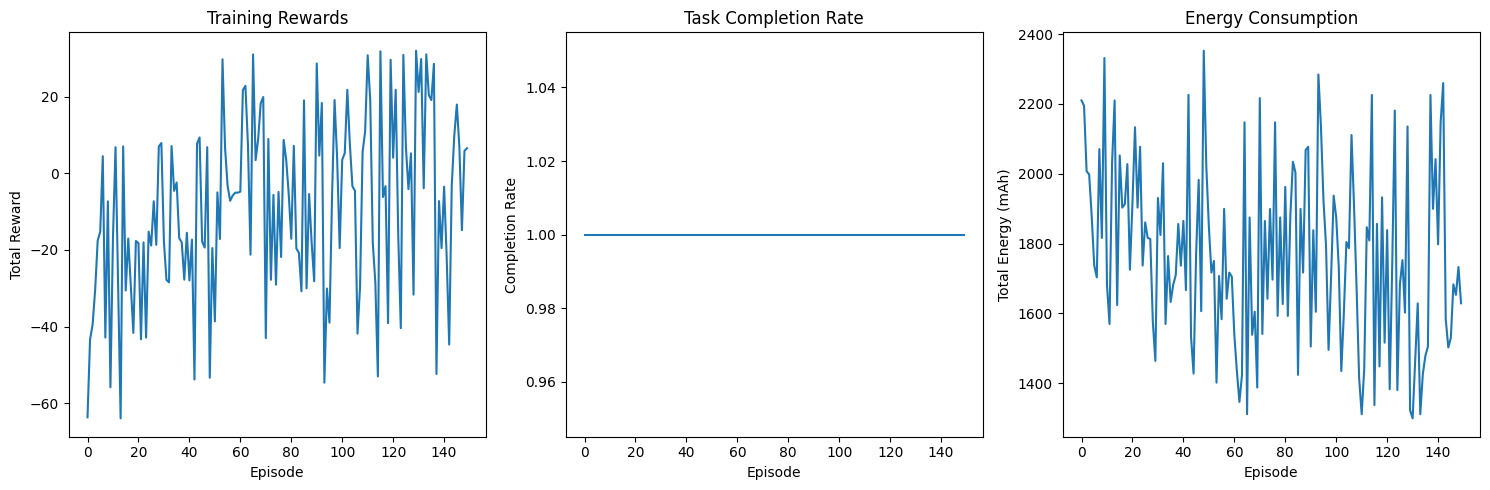

In [ ]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import pyRAPL
import psutil
from GPUtil import GPUtil
import time 
import platform
import pynvml


class EnergyTracker:
    def __init__(self):
        # Hardware-specific TDP values
        self.CPU_TDP = 45    # Watts (i5-9300H)
        self.GPU_TDP = 50    # Watts (GTX 1650 mobile)
        
        # Initialize GPU monitoring
        try:
            pynvml.nvmlInit()
            self.gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
            self.gpu_power_limit = pynvml.nvmlDeviceGetPowerManagementLimit(self.gpu_handle) / 1000
        except:
            self.gpu_power_limit = self.GPU_TDP
            self.gpu_handle = None

    def start(self):
        self.start_time = time.time()
        self.initial_cpu_usage = psutil.cpu_percent()
        self.initial_gpu_power = self._get_gpu_power()

    def _get_gpu_power(self):
        """Get GPU power in watts using NVML if available"""
        try:
            return pynvml.nvmlDeviceGetPowerUsage(self.gpu_handle) / 1000
        except:
            # Fallback to TDP-based estimation
            gpus = GPUtil.getGPUs()
            if gpus:
                return self.gpu_power_limit * gpus[0].load
            return 0

    def stop(self):
        duration = time.time() - self.start_time
        
        # CPU Energy Calculation
        final_cpu_usage = psutil.cpu_percent()
        avg_cpu_usage = (self.initial_cpu_usage + final_cpu_usage) / 200  # Convert % to fraction
        cpu_energy = (self.CPU_TDP * avg_cpu_usage * duration) / 3600  # Wh

        # GPU Energy Calculation
        final_gpu_power = self._get_gpu_power()
        if self.gpu_handle:  # Use actual measurements if available
            avg_gpu_power = (self.initial_gpu_power + final_gpu_power) / 2
            gpu_energy = (avg_gpu_power * duration) / 3600
        else:  # Fallback to TDP estimation
            gpu_energy = (self.GPU_TDP * (final_gpu_power/self.GPU_TDP) * duration) / 3600

        return {
            "cpu_wh": cpu_energy ,
            "gpu_wh": gpu_energy ,
            "total_wh": (cpu_energy + gpu_energy),
            "duration": duration
        }

# -------------------------------
# Prioritized Replay Buffer (Fixed)
# -------------------------------
class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, alpha=0.6):
        priorities = self.priorities[:len(self.buffer)] ** alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-0.5)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

# -------------------------------------------
# Mobile Edge Computing Environment (Updated)
# -------------------------------------------
class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10):
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        
        # Mobile Devices (MD) parameters
        self.md_compute = np.random.uniform(1.0, 3.0, num_md)        # GHz
        self.md_battery = np.random.randint(3000, 5001, num_md)      # mAh
        self.md_energy_local = np.random.uniform(1000, 3000, num_md) # mA/s (processing)
        self.md_energy_tx = np.random.uniform(0.1, 0.3, num_md)      # mAh per MB (transmission)
        
        # Edge Servers (ES) parameters
        self.es_compute = np.random.uniform(3.0, 5.0, num_es)        # GHz
        self.es_battery = np.random.randint(10000, 20001, num_es)    # mAh
        self.es_energy_process = np.random.uniform(500, 1500, num_es) # mA/s (processing)
        
        # Task parameters
        self.task_requirements = np.random.randint(100, 500, num_tasks)  # MB
        self.task_to_md = np.random.randint(0, num_md, num_tasks)  # Assign tasks to MDs
        
        self.reset()

    def reset(self):
        # Reset batteries to initial values
        self.md_battery = np.random.randint(3000, 5001, self.num_md)
        self.es_battery = np.random.randint(10000, 20001, self.num_es)
        
        self.current_task = 0
        self.completed_tasks = 0
        self.total_energy = 0
        self.violations = 0
        return self._get_state()

    def _get_state(self):
        if self.current_task >= self.num_tasks:
            return np.zeros(self.state_size)
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        
        # Normalize values
        state = [
            self.md_battery[md_idx] / 5000,
            self.md_compute[md_idx] / 3.0,
            task_size / 500,
            self.md_energy_local[md_idx] / 3000,
            self.md_energy_tx[md_idx] / 0.3
        ]
        
        # Add ES parameters
        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / 20000,
                self.es_compute[es_idx] / 5.0,
                self.es_energy_process[es_idx] / 1500
            ])
        
        # Add task progress
        state.append(self.current_task / self.num_tasks)
        
        self.state_size = len(state)
        return np.array(state)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return np.zeros(self.state_size), 0, True, {}
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        reward = 0
        done = False
        success = False
        device_used = ""
        energy_consumed = 0
        
        # Capture initial battery states
        initial_md_battery = self.md_battery[md_idx]
        initial_es_battery = self.es_battery[action-1] if action != 0 else 0

        # Process current task
        if action == 0:  # Local processing
            task_cycles = task_size * 1e6  # Convert MB to cycles
            processing_time = task_cycles / (self.md_compute[md_idx] * 1e9)  # Seconds
            energy_needed = processing_time * self.md_energy_local[md_idx]  # mA
            
            if initial_md_battery >= energy_needed:
                # Successful local processing
                self.md_battery[md_idx] -= energy_needed
                self.total_energy += energy_needed
                self.completed_tasks += 1
                
                # Reward components
                task_value = (task_size / 500) * 15  # Base reward scaled by task size
                energy_efficiency = (energy_needed / task_size) * 3  # Penalize energy per MB
                battery_impact = (energy_needed / initial_md_battery) * 8  # Penalize battery drain
                
                reward = task_value - energy_efficiency - battery_impact
                success = True
                energy_consumed = energy_needed
                device_used = f"MD{md_idx}"
            else:
                # Failed local processing
                self.violations += 1
                reward = -(task_size / 500) * 15  # Penalty proportional to task size
                self.md_battery[md_idx] = 0
        else:  # Offload to ES
            es_idx = action - 1
            if es_idx >= self.num_es:
                es_idx = self.num_es - 1
                
            # Transmission energy (per-MB rate)
            tx_energy = task_size * self.md_energy_tx[md_idx]
            
            # Edge processing (time-based)
            task_cycles = task_size * 1e6  # Convert MB to cycles
            processing_time = task_cycles / (self.es_compute[es_idx] * 1e9)  # Seconds
            process_energy = processing_time * self.es_energy_process[es_idx]  # mA
            
            if (initial_md_battery >= tx_energy and 
                self.es_battery[es_idx] >= process_energy):
                
                # Successful offload
                self.md_battery[md_idx] -= tx_energy
                self.es_battery[es_idx] -= process_energy
                self.total_energy += tx_energy + process_energy
                self.completed_tasks += 1

                # Reward components
                task_value = (task_size / 500) * 15
                total_energy = tx_energy + process_energy
                energy_efficiency = (total_energy / task_size) * 2.5
                md_impact = (tx_energy / initial_md_battery) * 5
                es_impact = (process_energy / self.es_battery[es_idx]) * 5
                
                reward = task_value - energy_efficiency - md_impact - es_impact
                success = True
                energy_consumed = total_energy
                device_used = f"ES{es_idx}"
            else:
                # Failed offload
                self.violations += 1
                reward = -(task_size / 500) * 15
                if self.md_battery[md_idx] < tx_energy:
                    self.md_battery[md_idx] = 0
                if self.es_battery[es_idx] < process_energy:
                    self.es_battery[es_idx] = 0
        
        # Print step details
        print(f"Task {self.current_task+1} ({task_size}MB) - Device: {device_used if success else 'None'}")
        if success:
            print(f"  Energy used: {energy_consumed:.1f}mAh")
            print(f"  MD{md_idx} battery: {self.md_battery[md_idx]:.1f}mAh")
            if action != 0:
                print(f"  ES{es_idx} battery: {self.es_battery[es_idx]:.1f}mAh")
        else:
            print("  Failed - insufficient battery")
        
        # Move to next task
        self.current_task += 1
        done = self.current_task >= self.num_tasks
        
        # Get next state
        next_state = self._get_state()
        
        # Episode completion bonus
        if done:
            completion_ratio = self.completed_tasks / self.num_tasks
            reward += completion_ratio * 20  # Scaled completion bonus
            reward -= (self.violations / self.num_tasks) * 25  # Scaled violation penalty
        
        return next_state, reward, done, {}

# -------------------------------
# Dueling DQN Agent (Updated)
# -------------------------------
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.train_interval = 1  # Train every 4th call
        self.train_counter = 0
        self.inference_batch = []
        self.inference_batch_size = 2
        self.model = self._build_dueling_dqn()
        self.target_model = self._build_dueling_dqn()
        self.update_target_network()

    def _build_dueling_dqn(self):
      inputs = tf.keras.Input(shape=(self.state_size,))
      x = tf.keras.layers.Dense(64, activation='relu')(inputs)
      x = tf.keras.layers.Dense(64, activation='relu')(x)

      # Value stream
      value = tf.keras.layers.Dense(32, activation='relu')(x)
      value = tf.keras.layers.Dense(1)(value)

      # Advantage stream
      advantage = tf.keras.layers.Dense(32, activation='relu')(x)
      advantage = tf.keras.layers.Dense(self.action_size)(advantage)

      # Corrected advantage calculation
      advantage_mean = tf.keras.layers.Lambda(lambda a: a - tf.reduce_mean(a, axis=1, keepdims=True))(advantage)

      # Combine streams
      outputs = tf.keras.layers.Add()([value, advantage_mean])

      model = tf.keras.Model(inputs=inputs, outputs=outputs)
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss="mse")

      return model


  

    def act(self, state):
        # Batch predictions for energy efficiency
        self.inference_batch.append(state)
        if len(self.inference_batch) < self.inference_batch_size:
            return np.random.randint(self.action_size)
        
        states = np.array(self.inference_batch)
        q_values = self.model.predict(states, verbose=0)
        self.inference_batch = []
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self):
        self.train_counter += 1
        if len(self.memory.buffer) < self.batch_size or self.train_counter % self.train_interval != 0:
            return

        samples, indices, weights = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        
        states = np.array(states)
        next_states = np.array(next_states)
        
        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        
        td_errors = []
        for i in range(self.batch_size):
            if dones[i]:
                target = rewards[i]
            else:
                target = rewards[i] + self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target
        
        self.model.fit(states, current_q, sample_weight=weights,
                      batch_size=self.batch_size, verbose=0)
        
        self.memory.update_priorities(indices, td_errors)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_target_network(self):
        # Update less frequently
        if self.train_counter % 5 == 0:
            self.target_model.set_weights(self.model.get_weights())
# -------------------------------
# Training and Evaluation (Updated)
# -------------------------------
def train_agent(episodes=100):
    tracker = EnergyTracker()
    env = MECEnvironment(num_md=3, num_es=2, num_tasks=10)
    state_size = env._get_state().shape[0]  # Initialize state size
    agent = DQNAgent(state_size=state_size, action_size=1 + env.num_es)
    
    rewards = []
    completion_rates = []
    energy_consumptions = []
    total_energy = 0.0
    total_cpu_energy = 0.0
    total_gpu_energy = 0.0
    
    # Energy-saving parameters
    min_replay_size = 512  # Wait for sufficient experiences
    update_frequency = 20  # Target network update interval
     
    
    for episode in range(episodes):
        tracker.start()
        state = env.reset()
        total_reward = 0
        done = False
        
        print(f"\n=== Episode {episode+1} ===")
        print("Initial Batteries:")
        print(f"MDs: {env.md_battery}")
        print(f"ESs: {env.es_battery}")
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if len(agent.memory.buffer) > min_replay_size:
                agent.replay()
        
        if episode % update_frequency == 0:
            agent.update_target_network()
            
        
       
        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks/env.num_tasks)
        energy_consumptions.append(env.total_energy)
        
        energy = tracker.stop()
        total_energy += energy['total_wh']
        total_cpu_energy += energy['cpu_wh']
        total_gpu_energy += energy['gpu_wh']
        
        print("\nEpisode Summary:")
        print(f"Completed tasks: {env.completed_tasks}/{env.num_tasks}")
        print(f"Total energy consumed: {env.total_energy:.1f}mAh")
        print(f"Final MD batteries: {np.round(env.md_battery, 1)}")
        print(f"Final ES batteries: {np.round(env.es_battery, 1)}")
        print(f"Total reward: {total_reward:.1f}")
        print(f"Epsilon: {agent.epsilon:.3f}\n")
        
        print(f"Energy Consumption:\n"
      f"  CPU: {energy['cpu_wh']*3600:.2f} J\n"
      f"  GPU: {energy['gpu_wh']*3600:.4f} J\n"
      f"  Total: {energy['total_wh']*3600:.4f} J")
    
    print(f"\nTraining Complete")
    print(f"Total Energy Used: {total_energy *3600:.2f} J")
    print(f"Total CPU Energy Used: {total_cpu_energy *3600:.2f} J")
    print(f"Total GPU Energy Used: {total_gpu_energy *3600:.2f} J")
    print(f"Average per Episode: {(total_energy/episodes)*3600:.2f} J")
    
    
    # Plot training results
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    plt.plot(rewards)
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1,3,2)
    plt.plot(completion_rates)
    plt.title('Task Completion Rate')
    plt.xlabel('Episode')
    plt.ylabel('Completion Rate')
    
    plt.subplot(1,3,3)
    plt.plot(energy_consumptions)
    plt.title('Energy Consumption')
    plt.xlabel('Episode')
    plt.ylabel('Total Energy (mAh)')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train_agent(episodes=150)

# Training with new params to reduce energy

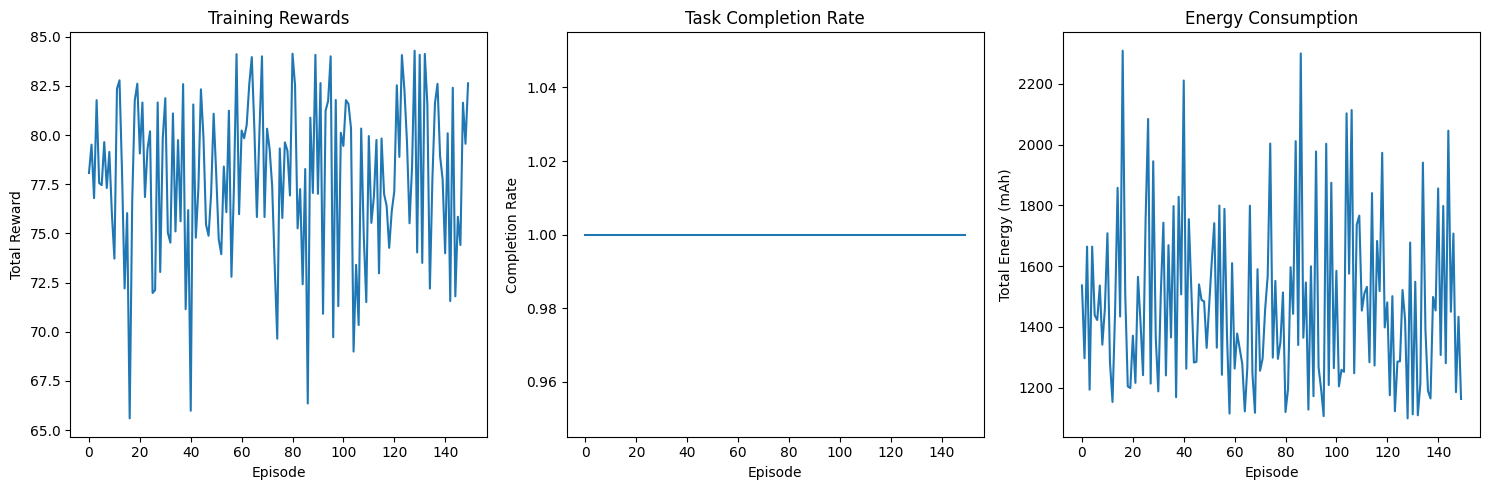


GPU Monitoring Mode: TDP_ESTIMATION

=== Episode 1 ===
Initial MD Batteries: [3937 3010 4653]
Initial ES Batteries: [13631 17106]
Task 1 (497MB) - Device: MD2
  Energy used: 499.8mAh
  MD2 battery: 4153.0mAh
Task 2 (230MB) - Device: MD0
  Energy used: 237.4mAh
  MD0 battery: 3699.0mAh
Task 3 (203MB) - Device: MD0
  Energy used: 209.6mAh
  MD0 battery: 3489.0mAh
Task 4 (168MB) - Device: MD0
  Energy used: 173.4mAh
  MD0 battery: 3315.0mAh
Task 5 (231MB) - Device: ES0
  Energy used: 158.5mAh
  MD1 battery: 2954.0mAh
  ES0 battery: 13528.0mAh
Task 6 (283MB) - Device: ES1
  Energy used: 70.8mAh
  MD0 battery: 3283.0mAh
  ES1 battery: 17066.0mAh
Task 7 (449MB) - Device: ES0
  Energy used: 328.5mAh
  MD2 battery: 4024.0mAh
  ES0 battery: 13328.0mAh
Task 8 (442MB) - Device: MD1
  Energy used: 442.1mAh
  MD1 battery: 2511.0mAh
Task 9 (473MB) - Device: ES1
  Energy used: 201.0mAh
  MD2 battery: 3888.0mAh
  ES1 battery: 17000.0mAh
Task 10 (288MB) - Device: ES0
  Energy used: 160.4mAh
  MD0 batt

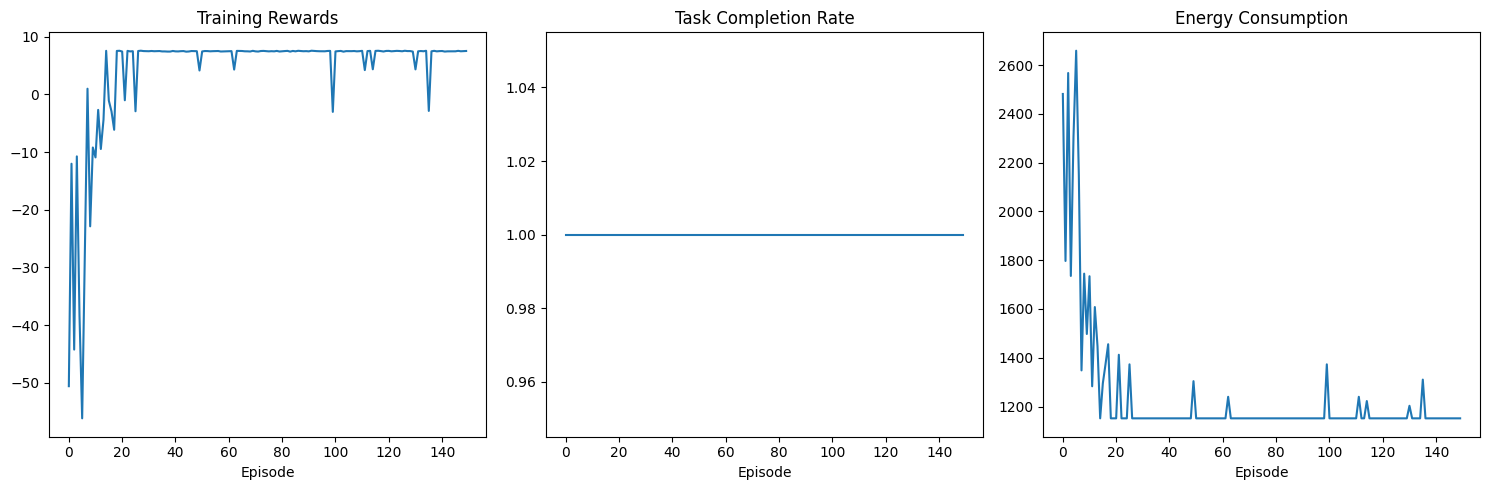

In [5]:
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import pyRAPL
import psutil
from GPUtil import GPUtil
import time 
import platform
import pynvml

class EnergyTracker:
    def __init__(self):
        self.CPU_TDP = 45    # Watts (i5-9300H)
        self.GPU_TDP = 50    # Watts (GTX 1650 mobile)
        self.gpu_mode = "tdp_estimation"
        try:
            pynvml.nvmlInit()
            self.gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
            self.gpu_power_limit = pynvml.nvmlDeviceGetPowerManagementLimit(self.gpu_handle) / 1000
            self.gpu_mode = "direct_measurement"
        except Exception as e:
            self.gpu_power_limit = self.GPU_TDP
            self.gpu_handle = None
            self.gpu_mode = "tdp_estimation"
        print(f"\nGPU Monitoring Mode: {self.gpu_mode.upper()}")

    def start(self):
        self.start_time = time.time()
        self.initial_cpu_usage = psutil.cpu_percent()
        self.initial_gpu_power = self._get_gpu_power()

    def _get_gpu_power(self):
        try:
            return pynvml.nvmlDeviceGetPowerUsage(self.gpu_handle) / 1000
        except:
            gpus = GPUtil.getGPUs()
            return self.gpu_power_limit * gpus[0].load if gpus else 0

    def stop(self):
        duration = time.time() - self.start_time
        final_cpu_usage = psutil.cpu_percent()
        avg_cpu_usage = (self.initial_cpu_usage + final_cpu_usage) / 200
        cpu_energy = (self.CPU_TDP * avg_cpu_usage * duration) / 3600

        final_gpu_power = self._get_gpu_power()
        if self.gpu_handle:
            avg_gpu_power = (self.initial_gpu_power + final_gpu_power) / 2
            gpu_energy = (avg_gpu_power * duration) / 3600
        else:
            gpu_energy = (self.GPU_TDP * (final_gpu_power/self.GPU_TDP) * duration) / 3600

        return {
            "cpu_wh": cpu_energy,
            "gpu_wh": gpu_energy,
            "total_wh": (cpu_energy + gpu_energy),
            "duration": duration
        }

class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros(capacity)
        self.pos = 0
        self.max_priority = 1.0

    def add(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.pos] = experience
        self.priorities[self.pos] = self.max_priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, alpha=0.6):
        priorities = self.priorities[:len(self.buffer)] ** alpha
        probs = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probs[indices]) ** (-0.5)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
        self.max_priority = max(self.max_priority, np.max(priorities))

class MECEnvironment:
    def __init__(self, num_md=3, num_es=2, num_tasks=10):
        self.num_md = num_md
        self.num_es = num_es
        self.num_tasks = num_tasks
        self.md_compute = np.random.uniform(1.0, 3.0, num_md)
        self.md_battery = np.random.randint(3000, 5001, num_md)
        self.md_energy_local = np.random.uniform(1000, 3000, num_md)
        self.md_energy_tx = np.random.uniform(0.1, 0.3, num_md)
        self.es_compute = np.random.uniform(3.0, 5.0, num_es)
        self.es_battery = np.random.randint(10000, 20001, num_es)
        self.es_energy_process = np.random.uniform(500, 1500, num_es)
        self.task_requirements = np.random.randint(100, 500, num_tasks)
        self.task_to_md = np.random.randint(0, num_md, num_tasks)
        self.energy_ratio_penalty = 0.005  # New energy tracking parameter
        self.reset()

    def reset(self):
        self.md_battery = np.random.randint(3000, 5001, self.num_md)
        self.es_battery = np.random.randint(10000, 20001, self.num_es)
        self.current_task = 0
        self.completed_tasks = 0
        self.total_energy = 0
        self.violations = 0
        return self._get_state()

    def _get_state(self):
        if self.current_task >= self.num_tasks:
            return np.zeros(self.state_size)
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        state = [
            self.md_battery[md_idx] / 5000,
            self.md_compute[md_idx] / 3.0,
            task_size / 500,
            self.md_energy_local[md_idx] / 3000,
            self.md_energy_tx[md_idx] / 0.3
        ]
        for es_idx in range(self.num_es):
            state.extend([
                self.es_battery[es_idx] / 20000,
                self.es_compute[es_idx] / 5.0,
                self.es_energy_process[es_idx] / 1500
            ])
        state.append(self.current_task / self.num_tasks)
        self.state_size = len(state)
        return np.array(state)

    def step(self, action):
        if self.current_task >= self.num_tasks:
            return np.zeros(self.state_size), 0, True, {}
        
        md_idx = self.task_to_md[self.current_task]
        task_size = self.task_requirements[self.current_task]
        reward = 0
        done = False
        success = False
        device_used = ""
        energy_consumed = 0
        
        initial_md_battery = self.md_battery[md_idx]
        initial_es_battery = self.es_battery[action-1] if action != 0 else 0

        if action == 0:  # Local processing
            task_cycles = task_size * 1e6
            processing_time = task_cycles / (self.md_compute[md_idx] * 1e9)
            energy_needed = processing_time * self.md_energy_local[md_idx]
            
            if initial_md_battery >= energy_needed:
                self.md_battery[md_idx] -= energy_needed
                self.total_energy += energy_needed
                self.completed_tasks += 1
                
                # Modified reward components
                task_value = (task_size / 500) * 5  # Reduced from 15
                energy_efficiency = (energy_needed / task_size) * 12  # Increased from 3
                battery_impact = (energy_needed / initial_md_battery) * 3  # Reduced from 8
                
                reward = task_value - energy_efficiency - battery_impact
                success = True
                energy_consumed = energy_needed
                device_used = f"MD{md_idx}"
            else:
                self.violations += 1
                reward = -(task_size / 500) * 5  # Reduced penalty
                self.md_battery[md_idx] = 0
        else:  # Offload processing
            es_idx = action - 1
            if es_idx >= self.num_es:
                es_idx = self.num_es - 1
                
            tx_energy = task_size * self.md_energy_tx[md_idx]
            task_cycles = task_size * 1e6
            processing_time = task_cycles / (self.es_compute[es_idx] * 1e9)
            process_energy = processing_time * self.es_energy_process[es_idx]
            
            if (initial_md_battery >= tx_energy and 
                self.es_battery[es_idx] >= process_energy):
                
                self.md_battery[md_idx] -= tx_energy
                self.es_battery[es_idx] -= process_energy
                self.total_energy += tx_energy + process_energy
                self.completed_tasks += 1

                # Modified reward components
                task_value = (task_size / 500) * 5  # Reduced from 15
                total_energy = tx_energy + process_energy
                energy_efficiency = (total_energy / task_size) * 10  # Increased from 2.5
                md_impact = (tx_energy / initial_md_battery) * 2  # Reduced from 5
                es_impact = (process_energy / self.es_battery[es_idx]) * 2  # Reduced from 5
                
                reward = task_value - energy_efficiency - md_impact - es_impact
                success = True
                energy_consumed = total_energy
                device_used = f"ES{es_idx}"
            else:
                self.violations += 1
                reward = -(task_size / 500) * 5  # Reduced penalty
                if self.md_battery[md_idx] < tx_energy:
                    self.md_battery[md_idx] = 0
                if self.es_battery[es_idx] < process_energy:
                    self.es_battery[es_idx] = 0

        print(f"Task {self.current_task+1} ({task_size}MB) - Device: {device_used if success else 'None'}")
        if success:
            print(f"  Energy used: {energy_consumed:.1f}mAh")
            print(f"  MD{md_idx} battery: {self.md_battery[md_idx]:.1f}mAh")
            if action != 0:
                print(f"  ES{es_idx} battery: {self.es_battery[es_idx]:.1f}mAh")
        else:
            print("  Failed - insufficient battery")
        
        self.current_task += 1
        done = self.current_task >= self.num_tasks
        next_state = self._get_state()
        
        if done:
            completion_ratio = self.completed_tasks / self.num_tasks
            reward += completion_ratio * 10  # Reduced from 20
            reward -= (self.violations / self.num_tasks) * 15  # Reduced from 25
            reward -= (self.total_energy / 5000) * 8  # New energy penalty
        
        return next_state, reward, done, {}

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.98  # Slower decay for more exploration
        self.learning_rate = 0.001
        self.model = self._build_dueling_dqn()
        self.target_model = self._build_dueling_dqn()
        self.update_target_network()

    def _build_dueling_dqn(self):
        inputs = tf.keras.Input(shape=(self.state_size,))
        x = tf.keras.layers.Dense(128, activation='relu')(inputs)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        value = tf.keras.layers.Dense(1)(x)
        advantage = tf.keras.layers.Dense(self.action_size)(x)
        mean_advantage = tf.keras.layers.Lambda(lambda a: tf.reduce_mean(a, axis=1, keepdims=True))(advantage)
        adjusted_advantage = tf.keras.layers.Subtract()([advantage, mean_advantage])
        outputs = tf.keras.layers.Add()([value, adjusted_advantage])
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.add((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory.buffer) < self.batch_size:
            return
        samples, indices, weights = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        states = np.array(states)
        next_states = np.array(next_states)
        current_q = self.model.predict(states, verbose=0)
        next_q = self.target_model.predict(next_states, verbose=0)
        td_errors = []
        for i in range(self.batch_size):
            target = rewards[i] if dones[i] else rewards[i] + self.gamma * np.max(next_q[i])
            delta = abs(current_q[i][actions[i]] - target)
            td_errors.append(delta)
            current_q[i][actions[i]] = target
        self.model.fit(states, current_q, sample_weight=weights, batch_size=self.batch_size, verbose=0)
        self.memory.update_priorities(indices, td_errors)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_agent(episodes=100):
    tracker = EnergyTracker()
    env = MECEnvironment(num_md=3, num_es=2, num_tasks=10)
    state_size = env._get_state().shape[0]
    agent = DQNAgent(state_size=state_size, action_size=1 + env.num_es)
    
    rewards = []
    completion_rates = []
    energy_consumptions = []
    total_energy = 0.0
    total_cpu_energy = 0.0
    total_gpu_energy = 0.0
    
    for episode in range(episodes):
        tracker.start()
        state = env.reset()
        total_reward = 0
        done = False
        
        print(f"\n=== Episode {episode+1} ===")
        print(f"Initial MD Batteries: {env.md_battery}")
        print(f"Initial ES Batteries: {env.es_battery}")
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if len(agent.memory.buffer) > agent.batch_size:
                agent.replay()
        
        if episode % 10 == 0:
            agent.update_target_network()
            
        rewards.append(total_reward)
        completion_rates.append(env.completed_tasks/env.num_tasks)
        energy_consumptions.append(env.total_energy)
        
        energy = tracker.stop()
        total_energy += energy['total_wh']
        total_cpu_energy += energy['cpu_wh']
        total_gpu_energy += energy['gpu_wh']
        
        print(f"\nCompleted: {env.completed_tasks}/{env.num_tasks}")
        print(f"Total Energy: {env.total_energy:.1f}mAh")
        print(f"Final Reward: {total_reward:.1f}")
        print(f"Epsilon: {agent.epsilon:.3f}")
        print(f"Energy Used: {energy['total_wh']*3600:.2f} J")
    
    print(f"\nTraining Complete")
    print(f"Total Energy Used: {total_energy *3600:.2f} J")
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(rewards)
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    
    plt.subplot(1,3,2)
    plt.plot(completion_rates)
    plt.title('Task Completion Rate')
    plt.xlabel('Episode')
    
    plt.subplot(1,3,3)
    plt.plot(energy_consumptions)
    plt.title('Energy Consumption')
    plt.xlabel('Episode')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train_agent(episodes=150)

Second Version with 